# Wisconsin Diagnostic Breast Cancer (WDBC) Data Analysis

In this notebook, we are analyzing data from breast cancer research to predict if a breast mass is begign or malignant. We have total 569 data points and 32 attributes. The first attribute is an ID column, second is our target variable and rest 30 are features of the mass, computed from a digitized image of a fine needle aspirate (FNA). The target class distribution for these sample points is 357 benign and 212 malignant.

## Importing Libraries

We start by importing all necessary libraries for our analysis.

In [1]:
# importing all necessary libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, tree, linear_model, naive_bayes
from sklearn.svm import SVC
from sklearn import datasets, preprocessing, metrics
from sklearn.metrics import f1_score, make_scorer, accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import scikitplot

import warnings
warnings.filterwarnings('ignore')

## Data Load

We then use pandas dataframe to load data in a python dataframe, giving column names as specified in the data dictionary. Out of the 30 features of the mass, first 10 attributs are mean, next 10 are standard errors, and the last 10 are the "worst" or largest values. The 10 features are:

    a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)
    
All feature values are recoded with four significant digits.

In [2]:
# load entire data in one numpy array
wdbc_raw = pd.read_csv('wdbc.data', delimiter=",", names=[
        'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 
        'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 
        'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 
        'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
        'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'])

Here, we are converting the pandas dataframe to a numpy array, as all data analysis is done using scikit learn, which is based on numpy. Doing this makes our analysis simpler.

In [3]:
# convert to numpy array
wdbc_raw = wdbc_raw.to_numpy()

## Training Testing Split

We then divide our data into training, validation and testing splits. The ratio of data being used is 80% training and 20% testing. Out of the 80% training, we again split 80% for training and the rest 20% for validation. The training and validation splits are used to train the model and select the best setting of hyperparameters. Once we have this setting, traning and validation splits are recombined to form a single training dataset used to train our prediction model. The final testing split, which the model has not seen as of now is being used to evaluate the final model performance.

In [4]:
# divide data into training and testing

wdbc_x = wdbc_raw[:, 2:].copy()
wdbc_y = wdbc_raw[:, 1:2].copy()

wdbc_x_train, wdbc_x_test, wdbc_y_train, wdbc_y_test = train_test_split(
                                          wdbc_x, wdbc_y, test_size=0.2, random_state=5)

wdbc_y_train = wdbc_y_train.ravel()
wdbc_y_test = wdbc_y_test.ravel()

#see sample division of training and testing
print("Sample count of training: ", wdbc_y_train.shape[0])
print("Sample count of testing: ", wdbc_y_test.shape[0])

Sample count of training:  455
Sample count of testing:  114


## Benchmark

We are now calculating model performance for the following model, where we are predicting everything as 'M'(we are interested in Malign diagnosis rather than benign, although the benign class is majority), and set it as a benchmark to see compare our final model performance.

We will use the F-measure for hyperparameter setting and final model selection, as it is a combination of precision and recall, and we want to maximize these measures for class 'M'.

In [5]:
pred = np.full(wdbc_y_test.shape, 'M')

print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y_test, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y_test, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y_test, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y_test, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y_test, pred))

Accuracy for this model:  0.32456140350877194
Precision for class M:  0.32456140350877194
Recall for class M:  1.0
F-score for this model:  0.490066225165563
Confusion Matrix for this model: 
 [[ 0 77]
 [ 0 37]]


## Pre processing

We define a dictionary here which will record the best performance evaluation of all the models we will look at.

In [6]:
f1_scores = {}

The below code is for defining the custom scorer, inner and outer cross validation folds, which will be used in evaluating all models.

In [7]:
# defining a custom scorer
# we use f-score for all our model evaluations
custom_scorer = make_scorer(f1_score, greater_is_better=True,  pos_label='M')

# code for accuracy scorer maker
# custom_scorer = make_scorer(accuracy_score, greater_is_better=True)

# create folds for cross validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=5)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=5)

## KNN

We start by normalizing the dataset, so that the distances calculated in KNN are not overweighed by a feature that has higher range as compared to others. Here, we use the min max normalizing technique.

In [8]:
# normalize train and validation
min_max_scaler = preprocessing.MinMaxScaler()
wdbc_x_train_minmax = min_max_scaler.fit_transform(wdbc_x_train)

We now evaluate KNN prediction model for different settings of hyperparameters using nested CV search. The scoring method we use is F-score, as we want to maximize both precision and recall for class M.
To do this, we first define a reasonable parameter search space. Post this, we use the custom scorer defined earlier, as an input in the grid search and cross val score functions.
We then use the inner and outer cross validation spaces. The inner cv is used in the grid search, and the outer cv is used in cross val score, and we store the mean f-score in our dictionary.
Additionally, we will be using the train split for all this analysis, as we want to reserve a part of data for final model evaluation.
At the end, we store the mean of KNN model evaluation in our dictionary.

In [9]:
# defining ranges for hyperparameters for KNN
p_grid_knn = {'n_neighbors' : range(1, 100), 'weights' : ['uniform', 'distance']}

# classifier
knn = neighbors.KNeighborsClassifier()

# inner CV
clf = GridSearchCV(estimator=knn, param_grid=p_grid_knn, 
                   cv=inner_cv, scoring=custom_scorer)

# outer CV
nested_score = cross_val_score(clf, X=wdbc_x_train_minmax, y=wdbc_y_train, 
                               cv=outer_cv, scoring=custom_scorer, error_score='raise')

f1_scores['knn'] = nested_score.mean()

## Decision Tree

We now take a look at decision tree. The process used is very similar to KNN. The difference from KNN here is instead of grid search, we use Bayesian search, as there are more parameters in Decision tree, and the search space is larger and hence takes a lot more time than performing grid search in KNN.

In [10]:
# defining search space for hyperparameters for Decision tree
p_grid_dtree = {'max_depth' : Integer(1, 20), 
          'min_samples_split': Integer(2,20), 
          'min_samples_leaf': Integer(1,10),
          'min_impurity_decrease': Real(0,2)
         }

# classifier
dtree = tree.DecisionTreeClassifier(criterion="gini")

# inner CV
clf = BayesSearchCV(estimator=dtree, search_spaces=p_grid_dtree, 
                   cv=inner_cv, scoring=custom_scorer)

# outer CV
nested_score = cross_val_score(clf, X=wdbc_x_train, y=wdbc_y_train, 
                               cv=outer_cv, scoring=custom_scorer, error_score='raise')

f1_scores['dtree'] = nested_score.mean()

## Logistic Regression

We now look at the logistic regression model and evaluate the performance of this model using the same strategy. To do this analysis, we first standardize features by removing the mean and scaling to unit variance.

In [11]:
wdbc_x_train_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x_train)

Code for hyperparameter tuning and performance validation.

In [12]:
# defining search space
p_grid_lreg = {
    'penalty' : Categorical(['l1', 'l2', 'none', 'elasticnet']), 
    'tol': Real(0,1),
    'C': Real(1,100),
    'max_iter': Integer(100,2000),
    'l1_ratio': Real(0,1)
}

# classifier
lreg = linear_model.LogisticRegression(solver='saga') 

# inner CV
clf = BayesSearchCV(estimator=lreg, search_spaces=p_grid_lreg, 
                   cv=inner_cv, scoring=custom_scorer)

# outer CV
nested_score = cross_val_score(clf, X=wdbc_x_train_scalar, y=wdbc_y_train, 
                               cv=outer_cv, scoring=custom_scorer, error_score='raise')

f1_scores['lreg'] = nested_score.mean()


## Support Vector Classifier

The final model we will be looking at is support vector classifier. We will follow the same steps with its respective parameters as in the above models. We use the z-score normalized dataset we used in the logistic regression above.

In [13]:
# defining search space
p_grid_svc = {
    'C': Real(1,100),
    'kernel' : Categorical(['linear', 'poly', 'rbf', 'sigmoid']), 
    'degree': Integer(1,5),
    'gamma': Real(0.000000001,1),
    'tol': Real(0.000000001,1)
}

# classifier
svc = SVC() 

# inner CV
clf = BayesSearchCV(estimator=svc, search_spaces=p_grid_svc, 
                   cv=inner_cv, scoring=custom_scorer)

# outer CV
nested_score = cross_val_score(clf, X=wdbc_x_train_scalar, y=wdbc_y_train, 
                               cv=outer_cv, scoring=custom_scorer, error_score='raise')

f1_scores['svc'] = nested_score.mean()

## Selecting Final Model

We now compare our F-measures on the training datasets for all the models we have built. 

In [14]:
f1_scores

{'knn': 0.9668613653699467,
 'dtree': 0.9145184098623662,
 'lreg': 0.9694166666666666,
 'svc': 0.9462652687099989}

In [15]:
best_f_score = max(f1_scores, key=f1_scores.get)
print(best_f_score)

lreg


We see that the F-score for Logistic Regression is the maximum out of the four models. We select the same as our final model.

## Evaluate performance of selected model - Logistic Regression

We now fit our selected model to the training data, and check peformance on training and test data, so that we evaluate model performance on some data which has not been seen by the model before.

In [16]:
# z score normalization
wdbc_x_train_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x_train)
wdbc_x_test_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x_test)
wdbc_x_scalar = preprocessing.StandardScaler().fit_transform(wdbc_x)

# build a custom scorer
custom_scorer = make_scorer(f1_score, greater_is_better=True,  pos_label='M')

# create folds for cross validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=5)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=5)

#search space for Bayesian hyperparameter setting
p_grid_lreg = {
    'penalty' : Categorical(['l1', 'l2', 'none', 'elasticnet']), 
    'tol': Real(0,1),
    'C': Real(1,100),
    'max_iter': Integer(100,2000),
    'l1_ratio': Real(0,1)
}

# classifier
lreg = linear_model.LogisticRegression(solver='saga') 


clf = BayesSearchCV(estimator=lreg, search_spaces=p_grid_lreg, 
                   cv=inner_cv, scoring=custom_scorer)
clf.fit(X=wdbc_x_train_scalar, y=wdbc_y_train)

pred = clf.predict(wdbc_x_scalar)
print("Accuracy for this model: ", metrics.accuracy_score(wdbc_y, pred))
print("Precision for class M: ", metrics.precision_score(wdbc_y, pred, pos_label='M'))
print("Recall for class M: ", metrics.recall_score(wdbc_y, pred, pos_label='M'))
print("F-score for this model: ", metrics.f1_score(wdbc_y, pred, pos_label='M'))
print("Confusion Matrix for this model: \n", metrics.confusion_matrix(wdbc_y, pred))

Accuracy for this model:  0.984182776801406
Precision for class M:  0.9903381642512077
Recall for class M:  0.9669811320754716
F-score for this model:  0.9785202863961814
Confusion Matrix for this model: 
 [[355   2]
 [  7 205]]


From the above we see that the overall accuracy of the model is around 98%. The presicion for class 'M' is around 0.99, i.e. out of all the data points predicted as class 'M', 99% of them have been correctly predicted. The recall for class 'M' is around 0.967, which means among all the data points which are actually 'M', 97% of them have been predicted as 'M' by our model. F-score for class 'M', which is shown above is around 0.98, which is calculated using precision and recall of class 'M'. Finally, we see the confusion matrix for the model. 

## Plotting ROC curve, calculating AUC and plotting lift curve.

ROC curve: The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection. The false-positive rate is also known as probability of false alarm and can be calculated as (1 − specificity). [ref: https://en.wikipedia.org/wiki/Receiver_operating_characteristic]

AUC: AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.[ref: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc]

Lift curve: The Lift curve shows the relation between the number of instances which were predicted positive and those that are indeed positive and thus measures the performance of a chosen classifier against a random classifier. The graph is constructed with the cumulative number of cases (in descending order of probability) on the x-axis and the cumulative number of true positives on the y-axis. Lift curve is often used in segmenting the population, e.g., plotting the number of responding customers against the number of all customers contacted. You can also determine the optimal classifier and its threshold from the graph. [ref: https://orange3.readthedocs.io/en/3.5.0/widgets/evaluation/liftcurve.html#:~:text=The%20Lift%20curve%20shows%20the,classifier%20against%20a%20random%20classifier.]

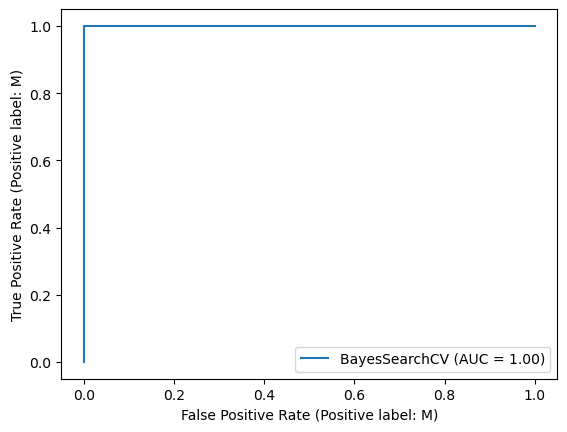

In [17]:
# roc curve plot
metrics.plot_roc_curve(clf, wdbc_x_scalar, pred)

In [18]:
#auc score
metrics.roc_auc_score(y_true=wdbc_y, y_score=clf.predict_proba(wdbc_x_scalar)[:,1])

0.9962343427937213

The AUC for our model is 0.997, i.e., there is 99.7% chance that our model will rank a random 'M' example more highly than a random 'B' example.

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

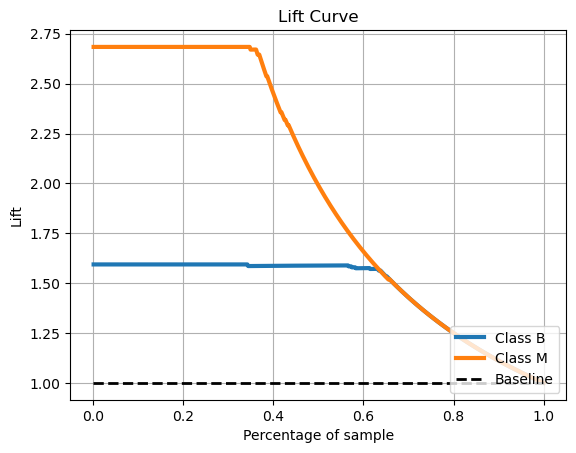

In [19]:
# lift curve
scikitplot.metrics.plot_lift_curve(wdbc_y, clf.predict_proba(wdbc_x_scalar))